
# <b> NLP </b>

## <b> Step1. Tokenization 방법</b>

###1.   koNLPy
```python
#영문
from nltk.tokenize import sent_tokenize, word_tokenize

#한글
from konlpy.tag import Okt
okt.morphs()
```

###2. Keras_Tokenizer (토근+벡터 한방에)

```python
from tensorflow.keras.preprocessing.text import Tokenizer

tknz = Tokenizer()
tknz.fit_on_texts([sentence]) #1. 단어별 인덱싱
LBE = tknz.texts_to_sequences([sentence]) #2. 원래문장 인코딩
from tensorflow.keras.utils import to_categorical
OHE = to_categorical(LBE) #3. 최종 원핫인코딩
```
---------------------------------------------------------
## <b> Step2. Vetorization 방법 </b> 

문자를 숫자로(인코딩), 동일한 차원크기의 백터로 맞춰주는 두가지 역할 수행 (인코딩 = ['정수인코딩', '원핫인코딩'])
###1. word2vec 
  - one-hot encoding 
  - window를 이동하며 생성된 데이터로 임베딩 학습 (cbow, skip-gram)

#### word2vec_gensim Library 
```python
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data,
                 vector_size = 256,
                 window = 3,
                 min_count = 5,
                 sg = 1)

model.wv.most_similar(positive = ['액션'], 
                      topn = 5)
```

###2. Embedding Layer
 - word2vec 과  완전히 동일한 역할은 아니지만 차원크기를 256으로 맞춰줌

```python
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(input_dim = 20000, output_dim = 256))  #뒤에 +Flatten 및 Dense Layer 가 나올때만 input_length를 필수로 작성해줘야함
model.add(layers.LSTM(32)) #embedding 레이어 뒤에 lstm이 오면 flatten() 과정이 필요없다. 하지만 바로 dense layer가 올 경우 필요
model.add(layers.Dense(1,activation = 'sigmoid'))
model.summary()
```
 - 위 model 학습을 위해선 input 크기를 사전에 맞춰줘야함 (32) _pad_sequence 이용

```python
from tensorflow.keras.preprocessing.sequence import pad_sequences
TV_X = pad_sequences(TV_X,
                    maxlen = 32,
                    padding = 'post')
```


# Embedding - Sentiment Analysis

## 네이버 영화 리뷰 데이터

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(linewidth = 200)

import tensorflow

# I. Naver Sentiment Movie Corpus v1.0

> ## 1) File Download

* train_data : 150,000
* test_data : 50,000

In [ ]:
tr_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
path_to_train_file = tensorflow.keras.utils.get_file('train.txt', tr_url)

te_url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
path_to_test_file = tensorflow.keras.utils.get_file('test.txt', te_url)

4893335/4893335 [==============================] - 0s 0us/step


> ## 2) train_data

* train_data DataFrame 정보

In [ ]:
train_data = pd.read_table(path_to_train_file)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


> ## 3) test_data

* test_data DataFrame 정보


In [ ]:
test_data = pd.read_table(path_to_test_file)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


> ## 4) concat( )

* DataFrame 합치기

> ### (1) 통합 DataFrame 생성

In [ ]:
DF = pd.concat([train_data, test_data], axis = 0, ignore_index = True)

In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


> ###  (2) 결측치 제거

* NULL값 행 제거 후 확인

In [ ]:
print(DF.isnull().sum())

id          0
document    8
label       0
dtype: int64


In [ ]:
DF = DF.dropna(how = 'any')

In [ ]:
print(DF.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199992 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        199992 non-null  int64 
 1   document  199992 non-null  object
 2   label     199992 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


# II. Data Preprocessing

> ## 1) 'document' 추출

In [ ]:
DF_X = DF.iloc[:, 1]

In [ ]:
DF_X[:4]

0                  아 더빙.. 진짜 짜증나네요 목소리
1    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                    너무재밓었다그래서보는것을추천한다
3        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
Name: document, dtype: object

> ## 2) 문장 및 단어 크기 조정

* 문장을 단어별 나누기

In [ ]:
sentences = [sentence.split(' ') for sentence in DF_X]

* 처리 결과 확인

In [ ]:
sentences[:4]

[['아', '더빙..', '진짜', '짜증나네요', '목소리'],
 ['흠...포스터보고', '초딩영화줄....오버연기조차', '가볍지', '않구나'],
 ['너무재밓었다그래서보는것을추천한다'],
 ['교도소', '이야기구먼', '..솔직히', '재미는', '없다..평점', '조정']]

* 문장을 단어 개수 순서로 정렬 후 시각화

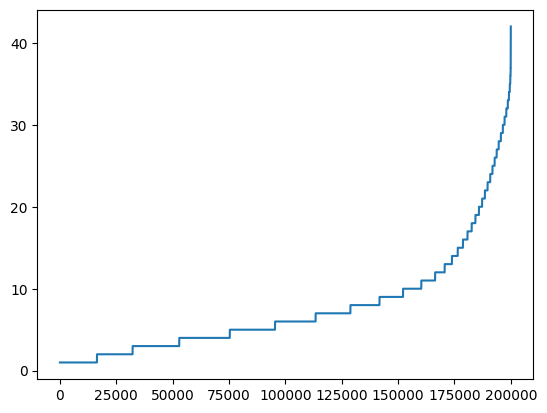

In [ ]:
import matplotlib.pyplot as plt

sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()

plt.plot(sentence_len)
plt.show()

* 32단어 이하의 문장 개수 확인

In [ ]:
print(sum([int(i <= 32) for i in sentence_len]))

198643


* 문장 앞 32개 단어만 추출 후 단어 길이를 5글자로 자르기

In [ ]:
sentences_new = []

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:32])

sentences = sentences_new

> ## 3) 처리 결과 확인

In [ ]:
sentences[:4]

[['아', '더빙..', '진짜', '짜증나네요', '목소리'],
 ['흠...포', '초딩영화줄', '가볍지', '않구나'],
 ['너무재밓었'],
 ['교도소', '이야기구먼', '..솔직히', '재미는', '없다..평', '조정']]

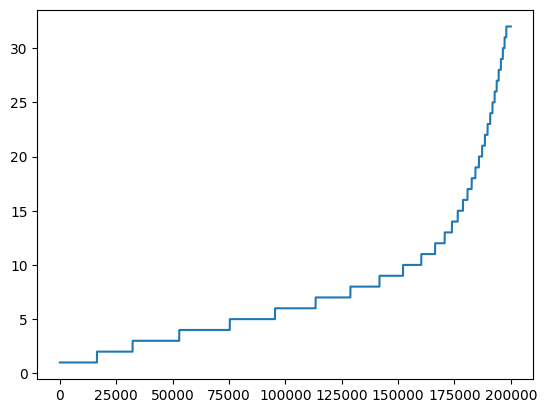

In [ ]:
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()

plt.plot(sentence_len)
plt.show()

> ## 4) 'label' - y

In [ ]:
y = DF.iloc[:, 2]

In [ ]:
len(y)

199992

# III. 'tokenizer( )' and 'pad_sequences( )'

> ## 1) Tokenization & Vectorization

* 빈도수 기준 상위 '20000' 종류 단어 사용

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(sentences)
TV_X = tokenizer.texts_to_sequences(sentences)

In [ ]:
TV_X[:5]

[[52, 4, 6732, 1107], [7368], [], [14748, 330, 13499], [93, 5596, 791, 485]]

> ## 2) pad_sequences( )

* 동일 길이(32) 벡터로 변경

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

TV_X = pad_sequences(TV_X,
                     maxlen = 32,
                     padding = 'post')

> ## 3) 처리 결과 확인

In [ ]:
print(TV_X[:5])

[[   52     4  6732  1107     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [ 7368     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [14748   330 13499     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0]
 [   93  5596   791   485     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0]]


In [ ]:
TV_X.shape

(199992, 32)

> ## 4) train_test_split( )

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(TV_X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 2045)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((139994, 32), (139994,), (59998, 32), (59998,))

# IV. Modeling

> ## 1) Model Define

 - Embedding Dimension : 256
    - Input_dim: 적용 단어 종류
    - output_dim: 임베딩 차원
 - Embedding 레이어는 input_shape 는 입력을 안 해줘도되는데 
 대신 input_dim 을 지정해줘야한다.

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Embedding(input_dim = 20000, 
                           output_dim = 256))  #뒤에 +Flatten 및 Dense Layer 가 나올때만 input_length를 필수로 작성해줘야함
model.add(layers.LSTM(32))  #embedding 레이어 뒤에 lstm이 오면 flatten() 과정이 필요없다. 하지만 바로 dense layer가 올 경우 필요
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 lstm (LSTM)                 (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,157,025
Trainable params: 5,157,025
Non-trainable params: 0
_________________________________________________________________


> ## 2) Model Compile

In [ ]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 4분

In [ ]:
%%time

history = model.fit(X_train, y_train, 
                    epochs = 20, 
                    batch_size = 128, 
                    validation_data = (X_test, y_test))

Epoch 1/20
1094/1094 [==============================] - 57s 45ms/step - loss: 0.6345 - accuracy: 0.6433 - val_loss: 0.6302 - val_accuracy: 0.6611
Epoch 2/20
1094/1094 [==============================] - 13s 12ms/step - loss: 0.6133 - accuracy: 0.6947 - val_loss: 0.6180 - val_accuracy: 0.6733
Epoch 3/20
1094/1094 [==============================] - 12s 11ms/step - loss: 0.6138 - accuracy: 0.6906 - val_loss: 0.6407 - val_accuracy: 0.6530
Epoch 4/20
1094/1094 [==============================] - 10s 9ms/step - loss: 0.6368 - accuracy: 0.6596 - val_loss: 0.6488 - val_accuracy: 0.6399
Epoch 5/20
1094/1094 [==============================] - 10s 9ms/step - loss: 0.6485 - accuracy: 0.6411 - val_loss: 0.6580 - val_accuracy: 0.6225
Epoch 6/20
1094/1094 [==============================] - 10s 10ms/step - loss: 0.6620 - accuracy: 0.6161 - val_loss: 0.6702 - val_accuracy: 0.5968
Epoch 7/20
1094/1094 [==============================] - 10s 9ms/step - loss: 0.6744 - accuracy: 0.5867 - val_loss: 0.6848 - va

> ## 4) Visualization

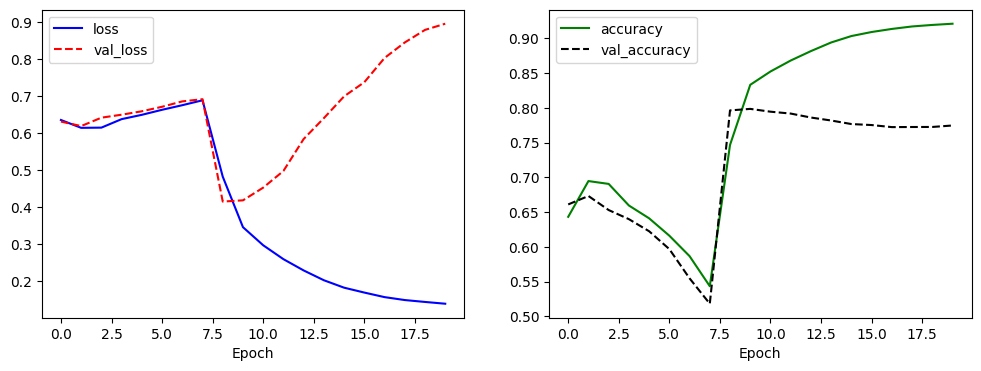

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

> ## 5) Model Evaluate

In [ ]:
model.evaluate(X_test, y_test, verbose = 0)

[0.8946363925933838, 0.7746758460998535]

# V. 문장 감성 분석

* 입력 단어에 따라서 감성 분석 결과 변화
 - 긍정('1') -> 부정('0')

In [ ]:
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')

test_sentences = []
now_sentence = []

for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding = 'post', maxlen = 32)

prediction = model.predict(test_X_1, verbose = 0)

for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

['재미있을']
[0.6841074]
['재미있을', '줄']
[0.0016311]
['재미있을', '줄', '알았는데']
[0.00961061]
['재미있을', '줄', '알았는데', '완전']
[0.00781015]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.00036321]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.00036897]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.00032796]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.00050328]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.00111121]


# 
# 
# 
# The End
# 
# 
# 